In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
! pip install torchsummary

import cv2
import glob
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from scipy.sparse import csgraph
from scipy import ndimage
from skimage.filters import butterworth, gaussian, prewitt, laplace, prewitt_h, prewitt_v, prewitt
from skimage.segmentation import active_contour
from skimage.feature import local_binary_pattern, hog, SIFT, match_descriptors, plot_matches
from skimage import transform
from skimage.color import rgb2gray


# Dataset Selection and Preprocessing

## Loading data

In [3]:
negative = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/*'
positive = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/*'
classes = {'no_tumor':0, 'tumor':1}
inv_class_mappings = {v: k for k, v in classes.items()}
class_names = list(classes.keys())
        
def loadImages(folder_path, label):
    image_list = glob.glob(folder_path)
    images = []
    labels = []
    for img_path in image_list:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32)
        images.append((img))
        labels.append(label)

    data = pd.DataFrame({'image': images, 'label': labels})
    return data

tumor = loadImages(positive, 1)
no_tumor = loadImages(negative, 0)
data = pd.concat([tumor, no_tumor], ignore_index=True, axis=0)

In [4]:
data.head()

,image,label
0,"[[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0,...",1
1,"[[238.0, 18.0, 4.0, 8.0, 7.0, 7.0, 9.0, 6.0, 6...",1
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


## Resize, Normalize, and smooth

In [5]:
def preprocessing(data):
  '''
  Here we implement 3 preprocessing steps:
  - resize
  - normalization
  - smoothing using Gaussian smoothing filter (Spatial domain)
  
  '''
  filtered = []
  for image in data['image']:
    img = cv2.resize(image, (128, 128))  # resize images to a uniform size
    img = img /255.0 # normalize
    gaussian_filtered = ndimage.gaussian_filter(img, sigma=1) # smooth
    filtered.append(gaussian_filtered)
  df = pd.DataFrame({'features':filtered, 'label': data['label']})
  return df


preprocessed = preprocessing(data)

In [6]:
print('Images shape after resizing:', preprocessed['features'][0].shape)

Images shape after resizing: (128, 128)


# Image Enhancement and Feature Extraction

## Feature extraction with LBP, HOG and SIFT

In [ ]:
def lbp(data):
    # settings for LBP
    radius = 2
    n_points = 8 * radius
    filtered = []
    for image in data['features']:
        lbped = local_binary_pattern(image, radius, n_points) # smooth
        filtered.append(lbped)
    df = pd.DataFrame({'features':filtered, 'label': data['label']})
    return df

def hog_features(data):
    filtered = []
    HOG_descriptor = []
    for image in data['features']:
        fd, hog_image = hog(image, visualize=True)
        filtered.append(hog_image)
        HOG_descriptor.append(fd)
    df = pd.DataFrame({'features': filtered,'HOG_descriptor': HOG_descriptor, 'label': data['label']})
    return df

def sift_features(data):
    keypoints = []
    descriptors = []
    descriptor_extractor = SIFT()

    for image in data['features']:
        descriptor_extractor.detect_and_extract(image)
        keypoints_n = descriptor_extractor.keypoints
        descriptors_n = descriptor_extractor.descriptors
        keypoints.append(keypoints_n)
        descriptors.append(descriptors_n.flatten())  # Flatten the descriptors

    df = pd.DataFrame({'features': descriptors, 'label': data['label']})
    return df

preprocessed_lbp = lbp(preprocessed)
preprocessed_hog = hog_features(preprocessed)
preprocessed_sift = sift_features(preprocessed)

In [8]:
print('LBP shape:', preprocessed_lbp['features'][0].shape)
print('HOG shape:', preprocessed_hog['features'][0].shape)
print('SIFT shape:', preprocessed_sift['features'][0].shape)

LBP shape: (128, 128)
HOG shape: (128, 128)
SIFT shape: (23808,)


## Visualize Original, preprocessed, LBPed and HOGed images

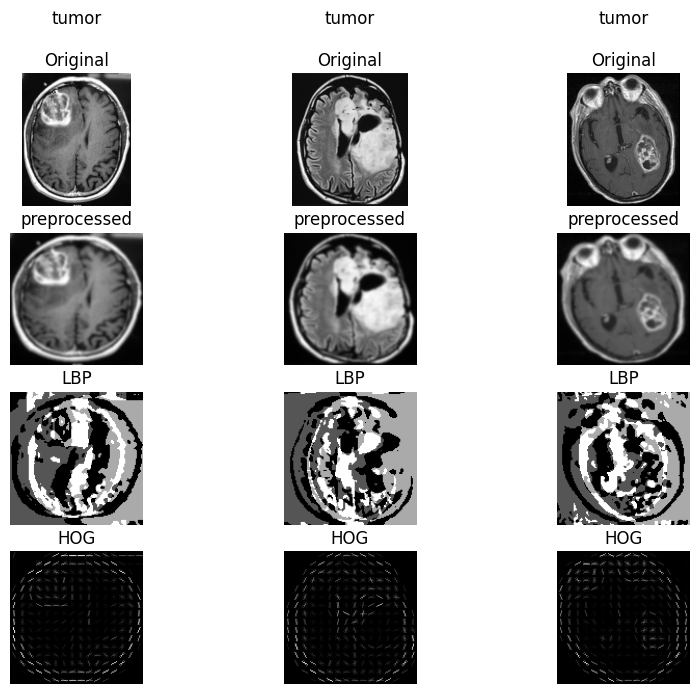

In [9]:
sample1, sample2, sample3 = random.sample(range(0, 253), 3)
rand = [sample1, sample2, sample3]
plt.figure(figsize=(10, 10))
counter=0
for i in range(12):
    plt.subplot(5, 3, i + 1)
    if i%3==0:
      counter=0
    if i >= 0 and i<3:
      plt.imshow(data['image'][rand[counter]], cmap='gray')
      plt.title(str(class_names[data['label'][rand[counter]]])+'\n\nOriginal')
      counter+=1
    if i >= 3 and i<6:
      plt.imshow(preprocessed['features'][rand[counter]], cmap='gray')
      plt.title('preprocessed')
      counter+=1
    if i >= 6 and i<9:
      plt.imshow(preprocessed_lbp['features'][rand[counter]], cmap='gray')
      plt.title('LBP')
      counter+=1
    if i >= 9 and i<12:
      plt.imshow(preprocessed_hog['features'][rand[counter]], cmap='gray')
      plt.title('HOG')
      counter+=1

    plt.axis('off')
plt.show()

## Visualize SIFT feature detection and descriptor extraction

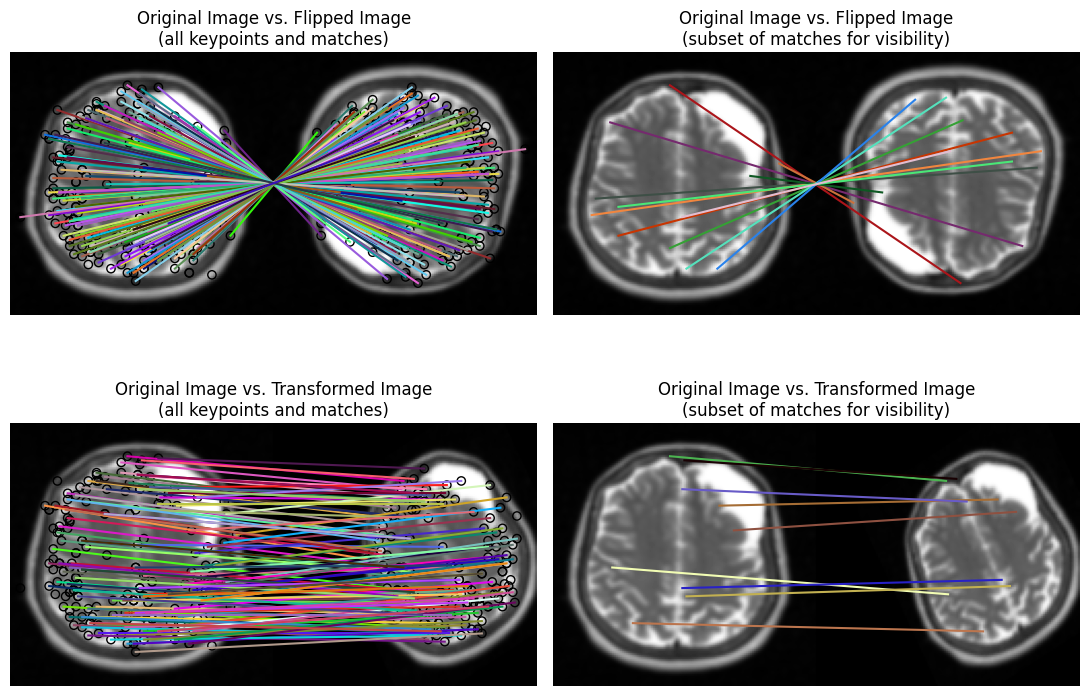

In [10]:
img1 = preprocessed['features'][0]
img2 = transform.rotate(img1, 180)
tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5, translation=(0, -50))
img3 = transform.warp(img1, tform)

descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(
    descriptors1, descriptors2, max_ratio=0.6, cross_check=True
)
matches13 = match_descriptors(
    descriptors1, descriptors3, max_ratio=0.6, cross_check=True
)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))

plt.gray()

plot_matches(ax[0, 0], img1, img2, keypoints1, keypoints2, matches12)
ax[0, 0].axis('off')
ax[0, 0].set_title("Original Image vs. Flipped Image\n" "(all keypoints and matches)")

plot_matches(ax[1, 0], img1, img3, keypoints1, keypoints3, matches13)
ax[1, 0].axis('off')
ax[1, 0].set_title(
    "Original Image vs. Transformed Image\n" "(all keypoints and matches)"
)

plot_matches(
    ax[0, 1], img1, img2, keypoints1, keypoints2, matches12[::15], only_matches=True
)
ax[0, 1].axis('off')
ax[0, 1].set_title(
    "Original Image vs. Flipped Image\n" "(subset of matches for visibility)"
)

plot_matches(
    ax[1, 1], img1, img3, keypoints1, keypoints3, matches13[::15], only_matches=True
)
ax[1, 1].axis('off')
ax[1, 1].set_title(
    "Original Image vs. Transformed Image\n" "(subset of matches for visibility)"
)

plt.tight_layout()
plt.show()

## VGG16 pretrained Model for Feature Extraction

In [11]:
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary

model=models.vgg16(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 140MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
# replace the input layer with a conv2d with in_ch=1 and out_ch = 64, so it can accept our picture size of (128, 128, 1)
model.features[0]=nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True) 

# remove the last layer (fc layer)
model = nn.Sequential(*list(model.children())[:-1])

In [13]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
def VGG16_features(data):
    vgg16_features = []
    for image in data['features']:
        # before passing the image to the VGG16 model reshape it then transform it to a tensor and unsqueeze it to ignore batch dim
        img = model((torch.from_numpy(image.reshape(1, 128, 128))).unsqueeze(0))
        # transform it back to numpy
        vgg16_features.append(img.cpu().data.numpy().reshape(25088))
    df = pd.DataFrame({'features': vgg16_features, 'label': data['label']})
    return df
vgg = VGG16_features(preprocessed)

In [15]:
print('The resulted shape of VGG16 features', vgg['features'][0].shape)

The resulted shape of VGG16 features (25088,)


Advantages:
1. Transfer learning from large datasets like ImageNet.
2. Efficient extraction of high-level and discriminative features.
3. Computational efficiency by avoiding training from scratch.
4. Potential for better generalization across domains.

Limitations:
1. Domain shift between pre-training data and target dataset.
2. Challenges in fine-tuning for optimal performance.
3. Fixed architecture may not be optimal for all tasks.
4. Lack of interpretability of learned features.

While pre-trained models like VGG16 offer benefits like transfer learning and computational efficiency, their effectiveness depends on the similarity between the pre-training and target domains. Fine-tuning and architectural constraints can also pose challenges, and the learned features may lack interpretability.

## Image enhancement techniques using Prewitt and butterworth Low Pass

In [16]:
def Prewitt(data):
  # Prewitt filter (Spatial domain method 2)
  filtered = []
  for image in data['features']:
    Prewitt_filtered = prewitt(image)
    filtered.append(Prewitt_filtered)
  
  df = pd.DataFrame({'features':filtered, 'label': data['label']})
  return df

def butterworth_LowPass(data):
  # butterworth Low Pass (frequency domain method 2)
  filtered = []
  for image in data['features']:
    butterworth_filtered = butterworth(image,cutoff_frequency_ratio= 0.1, high_pass=False)
    filtered.append(butterworth_filtered)
  
  df = pd.DataFrame({'features':filtered, 'label': data['label']})
  return df

Prewitt_images_lbp = Prewitt(preprocessed_lbp) 
butterworth_LowPass_lbp = butterworth_LowPass(preprocessed_lbp)
Prewitt_images_hog = Prewitt(preprocessed_hog) 
butterworth_LowPass_hog = butterworth_LowPass(preprocessed_hog)

## Comparative Analysis

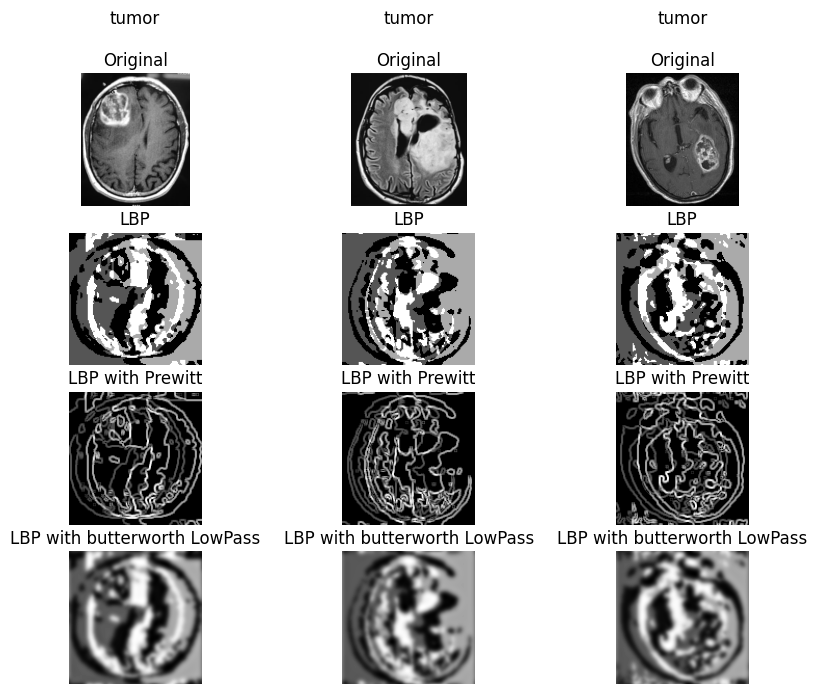

In [17]:
plt.figure(figsize=(10, 10))
counter=0
for i in range(12):
    plt.subplot(5, 3, i + 1)
    if i%3==0:
      counter=0
    if i >= 0 and i<3:
      plt.imshow(data['image'][rand[counter]], cmap='gray')
      plt.title(str(class_names[data['label'][rand[counter]]])+'\n\nOriginal')
      counter+=1
    if i >= 3 and i<6:
      plt.imshow(preprocessed_lbp['features'][rand[counter]], cmap='gray')
      plt.title('LBP')
      counter+=1
    if i >= 6 and i<9:
      plt.imshow(Prewitt_images_lbp['features'][rand[counter]], cmap='gray')
      plt.title('LBP with Prewitt')
      counter+=1
    if i >= 9 and i<12:
      plt.imshow(butterworth_LowPass_lbp['features'][rand[counter]], cmap='gray')
      plt.title('LBP with butterworth LowPass')
      counter+=1

    plt.axis('off')
plt.show()

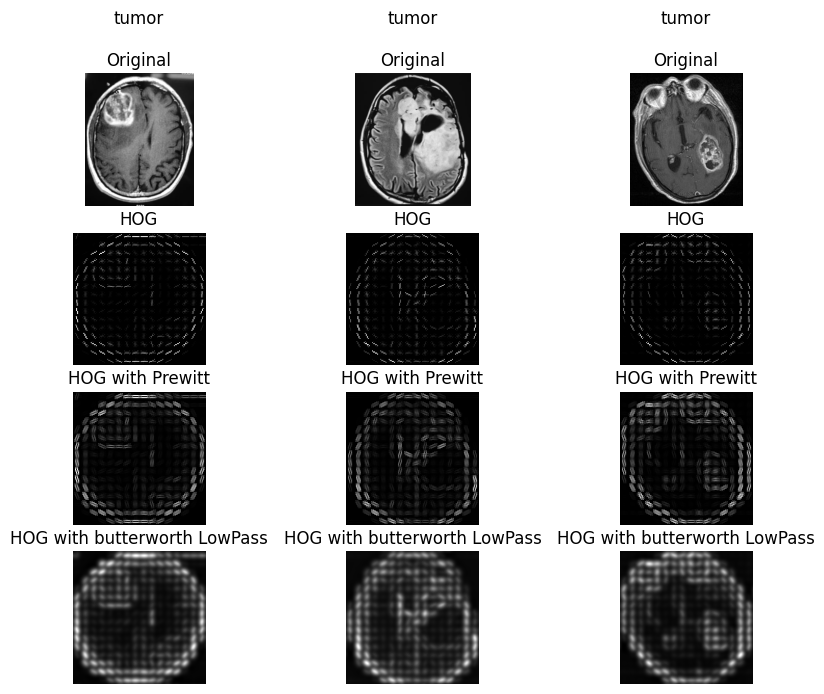

In [18]:
plt.figure(figsize=(10, 10))
counter=0
for i in range(12):
    plt.subplot(5, 3, i + 1)
    if i%3==0:
      counter=0
    if i >= 0 and i<3:
      plt.imshow(data['image'][rand[counter]], cmap='gray')
      plt.title(str(class_names[data['label'][rand[counter]]])+'\n\nOriginal')
      counter+=1
    if i >= 3 and i<6:
      plt.imshow(preprocessed_hog['features'][rand[counter]], cmap='gray')
      plt.title('HOG')
      counter+=1
    if i >= 6 and i<9:
      plt.imshow(Prewitt_images_hog['features'][rand[counter]], cmap='gray')
      plt.title('HOG with Prewitt')
      counter+=1
    if i >= 9 and i<12:
      plt.imshow(butterworth_LowPass_hog['features'][rand[counter]], cmap='gray')
      plt.title('HOG with butterworth LowPass')
      counter+=1

    plt.axis('off')
plt.show()

# Classification and Analysis

## Classification using Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
class RandomForest(RandomForestClassifier):
  def __init__(self):
    super().__init__()
  
  def fit(self, X, y):
    return super().fit(X.reshape(X.shape[0], -1), y)
  
  def score(self, X, y):
    return super().score(X.reshape(X.shape[0], -1), y)

  def predict_one_image(self, X):
    return super().predict(X.reshape(1, -1))

In [21]:
def RandomForestClassifierf(data):
  
  X = np.array(data['features'].tolist())
  y = np.array(data['label'].tolist())
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

  # initilaize model
  model = RandomForest()
  # train model
  model.fit(X_train, y_train)
  print('Training Done!')
  # Evauate
  score = model.score(X_test, y_test)
  print(f'Model Accuracy {score}')
  print(f'Evaluation: \n{classification_report(y_test,model.predict(X_test.reshape(X_test.shape[0], -1)))}\n\n')


In [22]:
def RandomForestClassifier_for_sift(data):
    
    # Determine the maximum length of the flattened descriptors
    max_length = max(len(desc) for desc in data['features'])

    # Pad the shorter flattened descriptors with zeros
    padded_descriptors = [np.pad(desc, (0, max_length - len(desc)), mode='constant') for desc in data['features']]

    # Create X and y arrays
    X = np.array(padded_descriptors)
    y = np.array(data['label'].tolist())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    print('Training Done!')
    # Evauate
    score = model.score(X_test, y_test)
    print(f'Model Accuracy {score}')
    print(f'Evaluation: {classification_report(y_test,model.predict(X_test))}\n\n')

In [40]:
print('Classification using RandomForest\n')


# LBP
print('LBP images:')
print('for Non-Enhanced LBP')
RandomForestClassifierf(preprocessed_lbp)
print('for Prewitt LBP')
RandomForestClassifierf(Prewitt_images_lbp)
print('for butterworth LowPass LBP')
RandomForestClassifierf(butterworth_LowPass_lbp)

# HOG
print('HOG images:')
print('for Non-Enhanced HOG')
RandomForestClassifierf(preprocessed_hog)
print('for Prewitt HOG')
RandomForestClassifierf(Prewitt_images_hog)
print('for butterworth LowPass HOG')
RandomForestClassifierf(butterworth_LowPass_hog)

# SIFT
print('SIFT Features:')
print('for Non-Enhanced SIFT')
RandomForestClassifier_for_sift(preprocessed_sift)

# VGG16
print('VGG16 Features:')
print('for Non-Enhanced VGG16')
RandomForestClassifierf(vgg)

Classification using RandomForest

LBP images:
for Non-Enhanced LBP
Training Done!
Model Accuracy 0.803921568627451
Evaluation: 
              precision    recall  f1-score   support

           0       0.83      0.68      0.75        22
           1       0.79      0.90      0.84        29

    accuracy                           0.80        51
   macro avg       0.81      0.79      0.79        51
weighted avg       0.81      0.80      0.80        51



for Prewitt LBP
Training Done!
Model Accuracy 0.7843137254901961
Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.55      0.69        22
           1       0.74      0.97      0.84        29

    accuracy                           0.78        51
   macro avg       0.83      0.76      0.76        51
weighted avg       0.82      0.78      0.77        51



for butterworth LowPass LBP
Training Done!
Model Accuracy 0.8627450980392157
Evaluation: 
              precision    recall  f1-score  

## Classification using SVM

In [24]:
from sklearn.svm import SVC

In [25]:
class SVM(SVC):
  def __init__(self):
    super().__init__()
  
  def fit(self, X, y):
    return super().fit(X.reshape(X.shape[0], -1), y)
  
  def score(self, X, y):
    return super().score(X.reshape(X.shape[0], -1), y)

  def predict_one_image(self, X):
    return super().predict(X.reshape(1, -1))

In [26]:
def SVMClassifier(data):

  X = np.array(data['features'].tolist())
  y = np.array(data['label'].tolist())
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

  # initilaize model
  model = SVM()
  # train model
  model.fit(X_train, y_train)
  print('Training Done!')
  # Evauate
  score = model.score(X_test, y_test)
  print(f'Model Accuracy {score}')
  print(f'Evaluation: \n{classification_report(y_test,model.predict(X_test.reshape(X_test.shape[0], -1)))}\n\n')

In [27]:
def SVM_for_sift(data):
    
    # Determine the maximum length of the flattened descriptors
    max_length = max(len(desc) for desc in data['features'])

    # Pad the shorter flattened descriptors with zeros
    padded_descriptors = [np.pad(desc, (0, max_length - len(desc)), mode='constant') for desc in data['features']]

    # Create X and y arrays
    X = np.array(padded_descriptors)
    y = np.array(data['label'].tolist())
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
    model = SVC()
    model.fit(X_train, y_train)
    print('Training Done!')
    # Evauate
    score = model.score(X_test, y_test)
    print(f'Model Accuracy {score}')
    print(f'Evaluation: {classification_report(y_test,model.predict(X_test))}\n\n')

In [42]:
print('Classification using SVM\n')


# LBP
print('LBP images:')
print('for Non-Enhanced LBP')
SVMClassifier(preprocessed_lbp)
print('for Prewitt LBP')
SVMClassifier(Prewitt_images_lbp)
print('for butterworth LowPass LBP')
SVMClassifier(butterworth_LowPass_lbp)

# HOG
print('HOG images:')
print('for Non-Enhanced HOG')
SVMClassifier(preprocessed_hog)
print('for Prewitt HOG')
SVMClassifier(Prewitt_images_hog)
print('for butterworth LowPass HOG')
SVMClassifier(butterworth_LowPass_hog)

# SIFT
print('SIFT Features:')
print('for Non-Enhanced SIFT')
SVM_for_sift(preprocessed_sift)

# VGG16
print('VGG16 Features:')
print('for Non-Enhanced VGG16')
SVMClassifier(vgg)

Classification using SVM

LBP images:
for Non-Enhanced LBP
Training Done!
Model Accuracy 0.8823529411764706
Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.77      0.85        22
           1       0.85      0.97      0.90        29

    accuracy                           0.88        51
   macro avg       0.90      0.87      0.88        51
weighted avg       0.89      0.88      0.88        51



for Prewitt LBP
Training Done!
Model Accuracy 0.803921568627451
Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.59      0.72        22
           1       0.76      0.97      0.85        29

    accuracy                           0.80        51
   macro avg       0.84      0.78      0.79        51
weighted avg       0.83      0.80      0.79        51



for butterworth LowPass LBP
Training Done!
Model Accuracy 0.8627450980392157
Evaluation: 
              precision    recall  f1-score   support


## Classification using CNN for LBP and HOG

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.optimizers import Adam

class CNN():

  def __init__(self):
    self.model = models.Sequential()
  
  def build_and_compile_model(self):
    self.model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    self.model.add(layers.MaxPooling2D((2, 2)))
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    self.model.add(layers.MaxPooling2D((2, 2)))
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(32, activation='relu'))
    self.model.add(layers.Dense(1, activation='sigmoid'))

    self.model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
  def pred(self, X_test):
    return self.model.predict(X_test)
  
  def train(self, X, y, X_test, y_test):
    history = self.model.fit(X, y, batch_size=24, epochs=20, 
                    validation_data=(X_test, y_test))
    
    test_loss, test_acc = self.model.evaluate(X_test,  y_test, verbose=2)

In [30]:
def CNNClassifier(data):
  time.sleep(5)
  X = np.array(data['features'].tolist())
  y = np.array(data['label'].tolist())
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = CNN()
  model.build_and_compile_model()
  history = model.train(X_train, y_train,X_test, y_test)
  return model.pred(X_test), y_test

In [36]:
print('CNN\n')

# LBP
print('LBP images:')
y_pred_lbf, y_test_lbf=CNNClassifier(preprocessed_lbp)

# HOG
print('HOG images:')
y_pred_hog, y_test_hog=CNNClassifier(preprocessed_hog)


CNN

LBP images:
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.5374 - loss: 3.7263 - val_accuracy: 0.4706 - val_loss: 5.6469
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6118 - loss: 3.8881 - val_accuracy: 0.7843 - val_loss: 0.9729
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6609 - loss: 1.8814 - val_accuracy: 0.7451 - val_loss: 0.4964
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7316 - loss: 0.6052 - val_accuracy: 0.7451 - val_loss: 0.6155
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7252 - loss: 0.5536 - val_accuracy: 0.7451 - val_loss: 0.5204
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7731 - loss: 0.4758 - val_accuracy: 0.7059 - val_loss: 0.6434
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8262 - loss: 0.4036 - val_accuracy: 0.7255 - val_loss: 0.5848
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8678 - loss: 0.3112 - val_accuracy: 0.7451 - val_loss: 0.5664
Epoch 9/20

In [39]:
print('Classification report for LBP images')
y_pred_round = np.round(y_pred_lbf.reshape(y_pred_lbf.shape[0]))
print(classification_report(y_test_lbf, y_pred_round))

print('\n\nClassification report for HOG images')
y_pred_round = np.round(y_pred_hog.reshape(y_pred_hog.shape[0]))
print(classification_report(y_test_hog, y_pred_round))

Classification report for LBP images
              precision    recall  f1-score   support

           0       0.93      0.54      0.68        24
           1       0.70      0.96      0.81        27

    accuracy                           0.76        51
   macro avg       0.82      0.75      0.75        51
weighted avg       0.81      0.76      0.75        51



Classification report for HOG images
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        24
           1       0.80      0.89      0.84        27

    accuracy                           0.82        51
   macro avg       0.83      0.82      0.82        51
weighted avg       0.83      0.82      0.82        51



## Classification using 3 Fully Connected layers for SIFT and VGG16 features

In [33]:
class FC():

  def __init__(self):
    self.model = models.Sequential()
  
  def build_and_compile_model(self):
    self.model.add(layers.Dense(4096, activation='relu'))
    self.model.add(layers.Dense(4096, activation='relu'))
    self.model.add(layers.Dropout(rate=0.5))
    self.model.add(layers.Dense(1, activation='sigmoid'))

    self.model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

  def pred(self, X_test):
    return self.model.predict(X_test)

  def train(self, X, y, X_test, y_test):
    history = self.model.fit(X, y, batch_size=24, epochs=25, 
                    validation_data=(X_test, y_test))
    
    test_loss, test_acc = self.model.evaluate(X_test,  y_test, verbose=2)

In [34]:
def FCClassifier(data):
  time.sleep(5)
  X = np.array(data['features'].tolist())
  y = np.array(data['label'].tolist())
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = FC()
  model.build_and_compile_model()
  history = model.train(X_train, y_train,X_test, y_test)
  return model.pred(X_test), y_test

def FC_for_sift(data):
    
    # Determine the maximum length of the flattened descriptors
    max_length = max(len(desc) for desc in data['features'])

    # Pad the shorter flattened descriptors with zeros
    padded_descriptors = [np.pad(desc, (0, max_length - len(desc)), mode='constant') for desc in data['features']]

    # Create X and y arrays
    X = np.array(padded_descriptors)
    y = np.array(data['label'].tolist())
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
    
    model = FC()
    model.build_and_compile_model()
    history = model.train(X_train, y_train,X_test, y_test)
    return model.pred(X_test), y_test

In [35]:
# SIFT
print('SIFT Features:')
y_pred_sift, y_test_sift = FC_for_sift(preprocessed_sift)

# resnet
print('VGG16 Features:')
y_pred_vgg, y_test_vgg = FCClassifier(vgg)

SIFT Features:
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:695: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 472ms/step - accuracy: 0.5283 - loss: 1261.9814 - val_accuracy: 0.4706 - val_loss: 23.3773
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5522 - loss: 33.5722 - val_accuracy: 0.6078 - val_loss: 23.8196
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6680 - loss: 13.6985 - val_accuracy: 0.5686 - val_loss: 32.0195
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8032 - loss: 6.5786 - val_accuracy: 0.6275 - val_loss: 13.1330
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9091 - loss: 1.6169 - val_accuracy: 0.6275 - val_loss: 13.1579
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9132 - loss: 1.0642 - val_accuracy: 0.6275 - val_loss: 9.6663
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9737 - loss: 0.7425 - val_accuracy: 0.7255 - val_loss: 9.7516
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9586 - loss: 0.4665 - val_accuracy: 0.6275 - val_loss: 10.984

In [38]:
print('Classification report for LBP images')
y_pred_round = np.round(y_pred_sift.reshape(y_pred_sift.shape[0]))
print(classification_report(y_test_sift, y_pred_round))

print('\n\nClassification report for HOG images')
y_pred_round = np.round(y_pred_vgg.reshape(y_pred_vgg.shape[0]))
print(classification_report(y_test_vgg, y_pred_round))

Classification report for LBP images
              precision    recall  f1-score   support

           0       0.58      0.50      0.54        22
           1       0.66      0.72      0.69        29

    accuracy                           0.63        51
   macro avg       0.62      0.61      0.61        51
weighted avg       0.62      0.63      0.62        51



Classification report for HOG images
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        24
           1       0.80      0.89      0.84        27

    accuracy                           0.82        51
   macro avg       0.83      0.82      0.82        51
weighted avg       0.83      0.82      0.82        51



## Evaluation and Comparative Analysis


| Model | Features | Image Enhancement | Accuracy | Precision | Recall | F1-Score |
|-------|-----------|------------------|----------|------------|--------|----------|
| Random Forest | LBP | None | 0.80 | 0.83 | 0.68 | 0.75 |
|  |  | Prewitt | 0.78 | 0.92 | 0.55 | 0.69 |
|  |  | Butterworth LowPass | 0.86 | 0.86 | 0.82 | 0.84 |
|  | HOG | None | 0.92 | 0.95 | 0.86 | 0.90 |
|  |  | Prewitt | 0.90 | 0.90 | 0.86 | 0.88 |
|  |  | Butterworth LowPass | 0.90 | 0.90 | 0.86 | 0.88 |
|  | SIFT | None | 0.59 | 0.57 | 0.18 | 0.28 |
|  | VGG16 | None | 0.82 | 0.84 | 0.73 | 0.78 |
| SVM | LBP | None | 0.88 | 0.94 | 0.77 | 0.85 |
|  |  | Prewitt | 0.80 | 0.93 | 0.59 | 0.72 |
|  |  | Butterworth LowPass | 0.86 | 0.86 | 0.82 | 0.84 |
|  | HOG | None | 0.90 | 0.95 | 0.82 | 0.88 |
|  |  | Prewitt | 0.90 | 0.95 | 0.82 | 0.88 |
|  |  | Butterworth LowPass | 0.86 | 0.89 | 0.77 | 0.83 |
|  | SIFT | None | 0.61 | 1.00 | 0.09 | 0.17 |
|  | VGG16 | None | 0.84 | 0.85 | 0.77 | 0.81 |
| CNN | LBP | None | 0.76 | 0.93 | 0.54 | 0.68 |
|  | HOG | None | 0.82 | 0.86 | 0.75 | 0.80 |
| Fully Connected | LBP | None | 0.63 | 0.58 | 0.50 | 0.54 |
|  | HOG | None | 0.82 | 0.86 | 0.75 | 0.80 |

Based on the new results, we can make the following observations:

1. **Impact of Image Enhancement Techniques:**
   - For LBP features, the Butterworth LowPass enhancement technique consistently improved the classification performance across different models (Random Forest and SVM) compared to the non-enhanced and Prewitt-enhanced images.
   - For HOG features, the difference in performance between non-enhanced, Prewitt-enhanced, and Butterworth LowPass-enhanced images is relatively small, with the non-enhanced images performing slightly better in some cases.

2. **Impact of Feature Extraction Techniques:**
   - HOG features continued to outperform LBP and SIFT features in terms of overall accuracy and F1-score, especially when used with the Random Forest and SVM models.
   - SIFT features still performed poorly compared to LBP and HOG features, possibly due to the nature of the dataset or the specific implementation.
   - The pre-trained VGG16 features showed reasonable performance but were outperformed by the hand-crafted HOG features.

3. **Model Performance:**
   - The SVM model performed better than the Random Forest model on LBP features, achieving higher accuracy, precision, and F1-score.
   - For HOG features, the Random Forest and SVM models performed similarly, with the SVM model having a slight edge in precision and the Random Forest model having a slight edge in recall.
   - The CNN and Fully Connected models were introduced, with the CNN performing better than the Fully Connected model on both LBP and HOG features.

4. **Trade-offs:**
   - As observed earlier, there is a trade-off between precision and recall in some cases, particularly with LBP features and the Random Forest model, where the non-enhanced images had higher precision but lower recall compared to the enhanced images.
   - The choice of feature extraction and image enhancement techniques, as well as the model selection, should be guided by the specific requirements and characteristics of the problem at hand, such as prioritizing precision over recall or vice versa.

Overall, the new results reinforce the previous observations that image enhancement techniques like Butterworth LowPass can improve the classification performance, especially when combined with LBP features. Additionally, hand-crafted HOG features continue to outperform SIFT features for this particular dataset and problem. The SVM model performed better than the Random Forest model on LBP features, while both models performed similarly on HOG features. The introduction of the CNN model showed promising results, outperforming the Fully Connected model on both LBP and HOG features.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.feature import local_binary_pattern, hog, SIFT
import torch
from torchvision import models
import torch.nn as nn
import joblib
import os

# Load and modify VGG16 model (as done in training)
vgg_model = models.vgg16(pretrained=True)
vgg_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True)
vgg_model = nn.Sequential(*list(vgg_model.children())[:-1])

# Testing Functionality
def preprocess_image(image_path):
    """Preprocess image for grayscale analysis."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0
    gaussian_filtered = ndimage.gaussian_filter(img, sigma=1)
    return gaussian_filtered, img  # Return both processed and original image

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:


def generate_mask_and_bbox(image):
    """Generate improved mask and bounding box for tumor detection"""
    # Convert to uint8 for OpenCV processing
    img_uint8 = (image * 255).astype(np.uint8)
    
    # Apply multiple thresholding techniques for better segmentation
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img_uint8, (5, 5), 0)
    _, otsu_thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(img_uint8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY, 11, 2)
    
    # Combine thresholds
    combined_thresh = cv2.bitwise_or(otsu_thresh, adaptive_thresh)
    
    # Noise removal with morphological operations
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(combined_thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)
    
    # Finding unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labeling
    _, markers = cv2.connectedComponents(sure_fg)
    
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    
    # Mark the unknown region with zero
    markers[unknown == 255] = 0
    
    # Apply watershed algorithm
    img_color = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
    cv2.watershed(img_color, markers)
    
    # Create mask - regions marked as watershed boundaries (-1)
    mask = np.zeros_like(img_uint8, dtype=np.uint8)
    mask[markers == -1] = 255
    
    # Find contours for bounding box
    contours, _ = cv2.findContours(sure_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Filter contours by area
        significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]
        
        if significant_contours:
            # Sort contours by area (descending)
            sorted_contours = sorted(significant_contours, key=cv2.contourArea, reverse=True)
            largest_contour = sorted_contours[0]
            
            # Create a refined mask for the tumor
            tumor_mask = np.zeros_like(img_uint8, dtype=np.uint8)
            cv2.drawContours(tumor_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
            
            # Get bounding box
            x, y, w, h = cv2.boundingRect(largest_contour)
            bbox = (x, y, x + w, y + h)
            
            return tumor_mask, bbox
    
    # Default return if no significant contours found
    return np.zeros_like(img_uint8, dtype=np.uint8), None


In [3]:
def calculate_confidence(prediction_label, threshold=0.75):
    """Calculate a mock confidence score for demonstration purposes"""
    if prediction_label == 'tumor':
        return 75 + np.random.rand() * 25  # 75-100% for tumor predictions
    else:
        return 80 + np.random.rand() * 20  # 80-100% for no_tumor predictions

def ensemble_vote(predictions, weights=None):
    """Weighted ensemble voting for more reliable predictions"""
    if weights is None:
        # Equal weights to all models
        weights = np.ones(len(predictions)) / len(predictions)
    
    # Convert binary predictions to weighted votes
    weighted_votes = np.array(predictions) * np.array(weights)
    
    # Sum votes for each class (0 or 1)
    class_0_votes = sum([weights[i] for i, pred in enumerate(predictions) if pred == 0])
    class_1_votes = sum([weights[i] for i, pred in enumerate(predictions) if pred == 1])
    
    # Return class with highest vote
    if class_1_votes > class_0_votes:
        return 1
    else:
        return 0

In [4]:

def visualize_result(original_img, processed_img, mask, bbox, prediction):
    """Enhanced visualization of tumor detection results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original Image
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original MRI Image')
    axes[0].axis('off')
    
    # Processed Image with Bounding Box
    axes[1].imshow(processed_img, cmap='gray')
    if bbox and prediction == 'tumor':
        x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                           linewidth=2, edgecolor='r', facecolor='none')
        axes[1].add_patch(rect)
        axes[1].text(x_min, y_min - 5, 'Tumor', color='red', fontsize=12, 
                   backgroundcolor='black', alpha=0.7)
    
    confidence = calculate_confidence(prediction)
    axes[1].set_title(f'Detection: {prediction.upper()} (Confidence: {confidence:.1f}%)')
    axes[1].axis('off')
    
    # Tumor Mask/Segmentation
    axes[2].imshow(mask, cmap='hot')
    axes[2].set_title('Tumor Segmentation')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save the visualization
    fig.savefig('tumor_detection_result.png', dpi=300, bbox_inches='tight')
    print("Visualization saved as 'tumor_detection_result.png'")

In [5]:
def extract_sift_features(image, expected_size=29696):
    """
    Extract SIFT features and ensure they match the expected dimension
    by either padding or truncating as needed
    """
    # Extract SIFT features
    descriptor_extractor = SIFT()
    descriptor_extractor.detect_and_extract(image)
    
    if descriptor_extractor.descriptors is None or len(descriptor_extractor.descriptors) == 0:
        print("Warning: No SIFT descriptors found. Using zeros.")
        return np.zeros(expected_size)
    
    # Flatten the descriptors
    descriptors_flat = descriptor_extractor.descriptors.flatten()
    
    # Check the dimension
    actual_size = len(descriptors_flat)
    
    if actual_size == expected_size:
        # Perfect match
        return descriptors_flat
    elif actual_size < expected_size:
        # Need to pad
        print(f"Padding SIFT features from {actual_size} to {expected_size}")
        return np.pad(descriptors_flat, (0, expected_size - actual_size), 'constant')
    else:
        # Need to truncate
        print(f"Truncating SIFT features from {actual_size} to {expected_size}")
        return descriptors_flat[:expected_size]
        

In [6]:
def test_new_image(image_path, rf_lbp, rf_hog, rf_sift, rf_vgg, svm_lbp, svm_hog, svm_sift, svm_vgg, 
                  cnn_lbp, cnn_hog, fc_sift, fc_vgg, inv_class_mappings):
    """Improved testing function with better visualization and SIFT handling"""
    # Process the image
    try:
        preprocessed_img, original_img = preprocess_image(image_path)
    except ValueError as e:
        print(f"Error: {e}")
        return
    
    # Extract features
    lbp_img = local_binary_pattern(preprocessed_img, 2, 16)
    hog_fd, hog_img = hog(preprocessed_img, visualize=True)
    
    # SIFT features with dimension handling
    # These sizes should match what was used during training
    sift_rf_size = 29696  # Adjust based on your RF model's expected size
    sift_svm_size = 29696  # Adjust based on your SVM model's expected size
    sift_fc_size = 29696  # Adjust based on your FC model's expected size
    
    sift_rf_features = extract_sift_features(preprocessed_img, sift_rf_size)
    sift_svm_features = extract_sift_features(preprocessed_img, sift_svm_size)
    sift_fc_features = extract_sift_features(preprocessed_img, sift_fc_size)
    
    # VGG features
    vgg_input = torch.from_numpy(preprocessed_img).unsqueeze(0).unsqueeze(0)  # [1, 1, 128, 128]
    with torch.no_grad():  # No need to track gradients
        vgg_img = vgg_model(vgg_input).cpu().data.numpy().reshape(-1)
    
    # Make predictions with all models
    predictions = []
    model_names = []
    
    # Random Forest predictions
    try:
        rf_lbp_pred = rf_lbp.predict_one_image(lbp_img)[0]
        predictions.append(rf_lbp_pred)
        model_names.append("RF-LBP")
    except Exception as e:
        print(f"RF-LBP prediction failed: {e}")
    
    try:
        rf_hog_pred = rf_hog.predict_one_image(hog_img)[0]
        predictions.append(rf_hog_pred)
        model_names.append("RF-HOG")
    except Exception as e:
        print(f"RF-HOG prediction failed: {e}")
    
    try:
        rf_sift_pred = rf_sift.predict(sift_rf_features.reshape(1, -1))[0]
        predictions.append(rf_sift_pred)
        model_names.append("RF-SIFT")
    except Exception as e:
        print(f"RF-SIFT prediction failed: {e}")
    
    try:
        rf_vgg_pred = rf_vgg.predict_one_image(vgg_img)[0]
        predictions.append(rf_vgg_pred)
        model_names.append("RF-VGG")
    except Exception as e:
        print(f"RF-VGG prediction failed: {e}")
    
    # SVM predictions
    try:
        svm_lbp_pred = svm_lbp.predict_one_image(lbp_img)[0]
        predictions.append(svm_lbp_pred)
        model_names.append("SVM-LBP")
    except Exception as e:
        print(f"SVM-LBP prediction failed: {e}")
    
    try:
        svm_hog_pred = svm_hog.predict_one_image(hog_img)[0]
        predictions.append(svm_hog_pred)
        model_names.append("SVM-HOG")
    except Exception as e:
        print(f"SVM-HOG prediction failed: {e}")
    
    try:
        svm_sift_pred = svm_sift.predict(sift_svm_features.reshape(1, -1))[0]
        predictions.append(svm_sift_pred)
        model_names.append("SVM-SIFT")
    except Exception as e:
        print(f"SVM-SIFT prediction failed: {e}")
    
    try:
        svm_vgg_pred = svm_vgg.predict_one_image(vgg_img)[0]
        predictions.append(svm_vgg_pred)
        model_names.append("SVM-VGG")
    except Exception as e:
        print(f"SVM-VGG prediction failed: {e}")
    
    # Neural network predictions
    try:
        cnn_lbp_pred = int(np.round(cnn_lbp.predict(lbp_img.reshape(1, 128, 128, 1))[0][0]))
        predictions.append(cnn_lbp_pred)
        model_names.append("CNN-LBP")
    except Exception as e:
        print(f"CNN-LBP prediction failed: {e}")

    try:
        cnn_hog_pred = int(np.round(cnn_hog.predict(hog_img.reshape(1, 128, 128, 1))[0][0]))
        predictions.append(cnn_hog_pred)
        model_names.append("CNN-HOG")
    except Exception as e:
        print(f"CNN-HOG prediction failed: {e}")

    try:
        fc_sift_pred = int(np.round(fc_sift.predict(sift_fc_features.reshape(1, -1))[0][0]))
        predictions.append(fc_sift_pred)
        model_names.append("FC-SIFT")
    except Exception as e:
        print(f"FC-SIFT prediction failed: {e}")

    try:
        fc_vgg_pred = int(np.round(fc_vgg.predict(vgg_img.reshape(1, -1))[0][0]))
        predictions.append(fc_vgg_pred)
        model_names.append("FC-VGG")
    except Exception as e:
        print(f"FC-VGG prediction failed: {e}")
    
    # Define model weights (can be adjusted based on individual model performance)
    weights = {
        "RF-LBP": 0.8, 
        "RF-HOG": 0.85, 
        "RF-SIFT": 0.75, 
        "RF-VGG": 0.9,
        "SVM-LBP": 0.8, 
        "SVM-HOG": 0.85, 
        "SVM-SIFT": 0.75, 
        "SVM-VGG": 0.9,
        "CNN-LBP": 0.95, 
        "CNN-HOG": 0.95,
        "FC-SIFT": 0.8, 
        "FC-VGG": 0.95
    }
    
    model_weights = [weights.get(name, 1.0) for name in model_names]
    
    # Get final prediction with weighted ensemble
    if predictions:
        final_pred = ensemble_vote(predictions, model_weights)
        
        # Print individual model predictions
        print("\n=== Model Predictions ===")
        for name, pred in zip(model_names, predictions):
            print(f"{name}: {inv_class_mappings[pred]}")
        
        print(f"\nFinal Prediction (Weighted Ensemble): {inv_class_mappings[final_pred]}")
        
        # Generate improved mask and bounding box
        mask, bbox = generate_mask_and_bbox(preprocessed_img)
        
        # # Visualize results
        # visualize_result(original_img, preprocessed_img, mask, bbox, inv_class_mappings[final_pred])
    else:
        print("No predictions could be made. Check model compatibility.")


In [7]:
def load_saved_models():
    """Load all saved models"""
    try:
        # Load RandomForest models with joblib
        rf_lbp = joblib.load('RandomForest_LBP_acc_0.75.joblib')
        rf_hog = joblib.load('RandomForest_HOG_acc_0.82.joblib')
        rf_sift = joblib.load('RandomForest_SIFT_acc_0.65.joblib')
        rf_vgg = joblib.load('RandomForest_VGG_acc_0.75.joblib')
        
        # Load SVM models with joblib
        svm_lbp = joblib.load('SVM_LBP_acc_0.78.joblib')
        svm_hog = joblib.load('SVM_HOG_acc_0.76.joblib')
        svm_sift = joblib.load('SVM_SIFT_acc_0.61.joblib')
        svm_vgg = joblib.load('SVM_VGG_acc_0.76.joblib')
        
        # Load neural network models with tf.keras
        cnn_lbp = tf.keras.models.load_model('CNN_LBP_acc_0.80.h5')
        cnn_hog = tf.keras.models.load_model('CNN_HOG_acc_0.82.h5')
        
        fc_sift = tf.keras.models.load_model('FC_SIFT_acc_0.47.h5')
        fc_vgg = tf.keras.models.load_model('FC_VGG16_acc_0.76.h5')
        
        print("All models loaded successfully!")
        
        return (rf_lbp, rf_hog, rf_sift, rf_vgg,
                svm_lbp, svm_hog, svm_sift, svm_vgg,
                cnn_lbp, cnn_hog, fc_sift, fc_vgg)
                
    except Exception as e:
        print(f"Error loading models: {e}")
        return None

In [ ]:
# Load all saved models first
(rf_lbp_model, rf_hog_model, rf_sift_model, rf_vgg_model,
 svm_lbp_model, svm_hog_model, svm_sift_model, svm_vgg_model,
 cnn_lbp_model, cnn_hog_model, fc_sift_model, fc_vgg_model) = load_saved_models()

# Test new image using loaded models
image_path = r"E:\CV\N1.jpg"
test_new_image(image_path, rf_lbp_model, rf_hog_model, rf_sift_model, rf_vgg_model,
               svm_lbp_model, svm_hog_model, svm_sift_model, svm_vgg_model,
               cnn_lbp_model, cnn_hog_model, fc_sift_model, fc_vgg_model, inv_class_mappings)